In [10]:
USE_CUDA = True

In [11]:
import subprocess
import sys
GITPATH = subprocess.run('git rev-parse --show-toplevel'.split(' '), \
        stdout=subprocess.PIPE).stdout.decode('utf-8').replace('\n','')
sys.path.append(GITPATH)
import dobroEnv

In [12]:
import os
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp

from utils_ju import soft_update, OrnsteinUhlenbeckProcess

In [13]:
gym.logger.set_level(40)

In [14]:
ENV_NAME = 'Pendulum-v0'
state_dim = 3
action_dim = 1

In [15]:
num_hidden1 = 64
num_hidden2 = 64

critic_lr = 1e-3
actor_lr = 1e-3

NUM_EPISODES = 1000
batch_size = 64
max_buff_size = 10000
warm_up = 500

decay_rate = 0.999
gamma = 0.99

print_freq = 10

In [16]:
class ActorNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNet, self).__init__()
        
        self.actor_layer = nn.Sequential(
            nn.Linear(state_dim, num_hidden1),
            nn.ReLU(),
            nn.Linear(num_hidden1, num_hidden2),
            nn.ReLU(),
            nn.Linear(num_hidden2, action_dim)
        )
    
    def forward(self, x):
        return self.actor_layer(x)
    
    
class CriticNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticNet, self).__init__()
        
        self.critic_layer = nn.Sequential(
            nn.Linear(state_dim+action_dim, num_hidden1),
            nn.ReLU(),
            nn.Linear(num_hidden1, num_hidden2),
            nn.ReLU(),
            nn.Linear(num_hidden2, 1)
        )
        
    def forward(self, state, action):
        x = torch.cat([state, action], dim=-1)
        return self.critic_layer(x)

In [17]:
def sample_minibatch(R, batch_size):
    minibatch = np.array(random.sample(R, batch_size))

    def array_to_tensor(minibatch, idx):
        if USE_CUDA:
            return torch.tensor(np.stack(minibatch[:, idx]).astype(np.float32)).cuda()
        else:
            return torch.tensor(np.stack(minibatch[:, idx]).astype(np.float32))

    states = array_to_tensor(minibatch, 0)
    actions = array_to_tensor(minibatch, 1)
    rewards = array_to_tensor(minibatch, 2)
    next_states = array_to_tensor(minibatch, 3)
    return states, actions, rewards, next_states

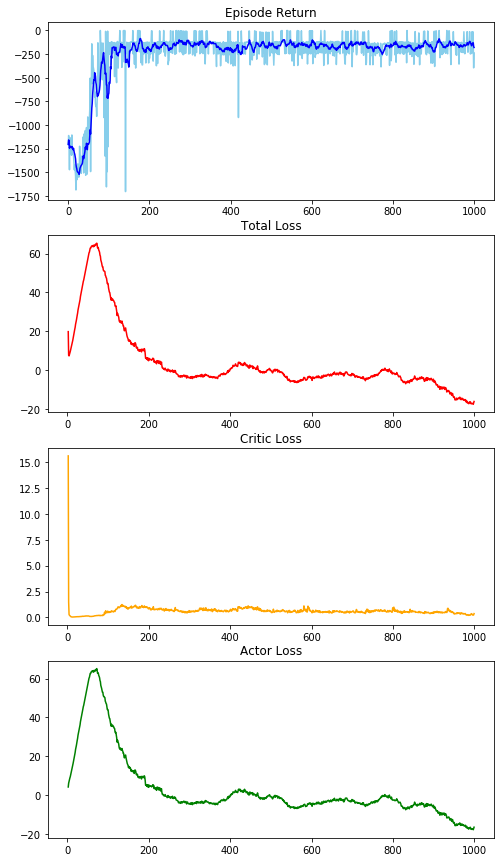

   running    EP       Loss       Return        LR
0     1.0%    10  11.367421 -1105.386407  0.000991
1     2.0%    20  22.049465 -1687.063859  0.000981
2     3.0%    30  33.818855 -1351.781534  0.000971
3     4.0%    40  45.667374 -1094.492355  0.000962
4     5.0%    50  55.671722 -1066.418530  0.000952
5     6.0%    60  63.806355  -563.431900  0.000943
6     7.0%    70  64.255417  -801.013041  0.000933
7     8.0%    80  60.621464    -0.294426  0.000924
8     9.0%    90  51.072384  -516.908375  0.000915
9    10.0%   100  44.758385  -124.663376  0.000906
10   11.0%   110  36.063015  -129.466093  0.000897
11   12.0%   120  33.154373  -551.784456  0.000888
12   13.0%   130  25.365173  -120.410820  0.000879
13   14.0%   140  20.948265    -0.138710  0.000870
14   15.0%   150  16.074286  -365.241957  0.000862
15   16.0%   160  13.095471    -1.549225  0.000853
16   17.0%   170  11.671629  -127.009744  0.000844
17   18.0%   180  10.084895  -340.871736  0.000836
18   19.0%   190  11.065123  -1

In [18]:
random_process = OrnsteinUhlenbeckProcess(theta=0.15, mu=0., sigma=0.2, size=action_dim)
criterion = nn.MSELoss()

cnet = CriticNet(state_dim, action_dim)
anet = ActorNet(state_dim, action_dim)
target_cnet = CriticNet(state_dim, action_dim)
target_anet = ActorNet(state_dim, action_dim)

if USE_CUDA:
    cnet.cuda()
    anet.cuda()
    target_cnet.cuda()
    target_anet.cuda()
    criterion.cuda()

target_cnet.load_state_dict(cnet.state_dict())
target_anet.load_state_dict(anet.state_dict())

critic_optim = optim.Adam(cnet.parameters(), lr=critic_lr, weight_decay=1e-5)
actor_optim = optim.Adam(anet.parameters(), lr=actor_lr, weight_decay=1e-5)
critic_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=critic_optim, gamma=decay_rate)
actor_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=actor_optim, gamma=decay_rate)

# training log
fignum = len([f for f in os.listdir() if 'DDPG_Pendulum' in f and 'png' in f])
log_actor_loss = []
log_critic_loss = []
log_total_loss = []
log_ep_return = []
log_avg_return = []
log_df = pd.DataFrame(columns=['running', 'EP', 'Loss', 'Return', 'LR'])

R = []
ridx = 0
env = gym.make(ENV_NAME)

for ne in range(NUM_EPISODES):
    # init random process N
    random_process.reset_states()
    obs = env.reset()
    state = torch.tensor(obs.astype(np.float32))
    if USE_CUDA:
        state = state.cuda()
    done = False

    ep_c_loss = []
    ep_a_loss = []
    ep_return = 0.
    
    time_step = 0
    while not done:
        time_step += 1
        state = torch.tensor(obs.astype(np.float32))
        if USE_CUDA:
            state = state.cuda()
            a = anet(state).cpu().detach().numpy()
        else:
            a = anet(state).detach().numpy()
        noise = random_process.sample()
        action = a + noise

        pre_obs = obs
        obs, reward, done, _ = env.step(action)
        ep_return += reward
        
        # [s_t, a_t, r_t, s_(t+1)]
        replay_data = [pre_obs, action, reward, obs]
        if len(R)<max_buff_size:
            R.append(replay_data)
            if len(R)<warm_up:
                continue
        else:
            R[ridx%max_buff_size] = replay_data
            ridx += 1
        
        # sample minibatch
#         minibatch = np.array(random.sample(R, batch_size))
#         states = torch.tensor(minibatch[:, 0])
#         actions = torch.tensor(minibatch[:, 1])
#         rewards = torch.tensor(minibatch[:, 2])
#         next_states = torch.tensor(minibatch[:, 3])
        states, actions, rewards, next_states = sample_minibatch(R, batch_size)
        
        next_actions = target_anet(next_states) # mu'(s_(i+1))
        next_q_values = target_cnet(next_states, next_actions) # q'(s_(i+1), mu'(s_(i+1)))
        y_targets = rewards + gamma * next_q_values.squeeze()
        q_values = cnet(states, actions).squeeze() # q(s_i, a_i)

        critic_loss = criterion(q_values, y_targets)
        cnet.zero_grad()
        critic_loss.backward()
        critic_optim.step()

        actor_loss = - cnet(states, anet(states)).mean()
        anet.zero_grad()
        actor_loss.backward()
        actor_optim.step()
        
        if USE_CUDA:
            ep_c_loss.append(critic_loss.cpu().detach().numpy())
            ep_a_loss.append(actor_loss.cpu().detach().numpy())
        else:
            ep_c_loss.append(critic_loss.detach().numpy())
            ep_a_loss.append(actor_loss.detach().numpy())

        # update target_anet, target_cnet
        soft_update(target_cnet, cnet)
        soft_update(target_anet, anet)
        
    ep_c_loss = np.mean(ep_c_loss)
    ep_a_loss = np.mean(ep_a_loss)
    ep_loss = ep_c_loss + ep_a_loss
    
    log_actor_loss.append(ep_a_loss)
    log_critic_loss.append(ep_c_loss)
    log_total_loss.append(ep_loss)
    log_ep_return.append(ep_return)
    log_avg_return.append(np.mean(log_ep_return[-10:]))
    
    
    if (ne+1)%print_freq==0:
        print('%d/%d episodes. (%.2f%%)'%(ne+1, NUM_EPISODES, (ne+1)/NUM_EPISODES*100))
        #print('Current learning rate:', optimizer.param_groups[0]['lr'])
        print('Total loss:\t', ep_loss)
        print('Critic\t\tActor')
        print('%.2f\t\t%.2f'%(ep_c_loss, ep_a_loss))
        print('Epside Return: [%.1f]'%ep_return)
        print('Episode length: %d'%time_step)
        print()
        
        clear_output()
        
        f, axes = plt.subplots(4,1)
        f.set_figheight(15)
        f.set_figwidth(8)
        
        axes[0].plot(log_ep_return, color='skyblue')
        axes[0].plot(log_avg_return, color='blue')
        axes[1].plot(log_total_loss, color='red')
        axes[2].plot(log_critic_loss, color='orange')
        axes[3].plot(log_actor_loss, color='green')

        axes[0].set_title('Episode Return')
        axes[1].set_title('Total Loss')
        axes[2].set_title('Critic Loss')
        axes[3].set_title('Actor Loss')
        plt.savefig('DDPG_Pendulum_%d.png'%fignum)
        plt.show()
        
        
        raw_data = ['%.1f%%'%((ne+1)/NUM_EPISODES*100), int(ne+1), ep_loss, ep_return, actor_optim.param_groups[0]['lr']]
        log_df = log_df.append(pd.Series(raw_data, index = log_df.columns), ignore_index=True)
        print(log_df)

    critic_scheduler.step()            
    actor_scheduler.step()

In [19]:
log_avg_return[-20:]

[-153.89770724668696,
 -152.80610941782487,
 -130.67731826127846,
 -130.38102617289965,
 -152.0247668757805,
 -151.5030855402264,
 -139.79239085307972,
 -128.7402842722723,
 -116.70267313108813,
 -116.57236325456707,
 -127.86043690896012,
 -138.43276023497782,
 -150.9142518895141,
 -162.57723342215212,
 -140.92206302191985,
 -142.30970631039534,
 -130.72109404362692,
 -131.17037714689428,
 -169.4555677953098,
 -180.2769756556234]